## Taking Causal Graph as Input

In [3]:
import networkx as nx
import pandas as pd
from dowhy.utils.timeseries import create_graph_from_csv,create_graph_from_user
from dowhy.utils.plotting import plot, pretty_print_graph

- The user can either create a csv file with the edges in the graph or input the edges manually


Graph edges with time lags:
1 -> 2 with time-lagged dependency 3
2 -> 3 with time-lagged dependency 4
5 -> 6 with time-lagged dependency 1
4 -> 7 with time-lagged dependency 4
7 -> 6 with time-lagged dependency 3


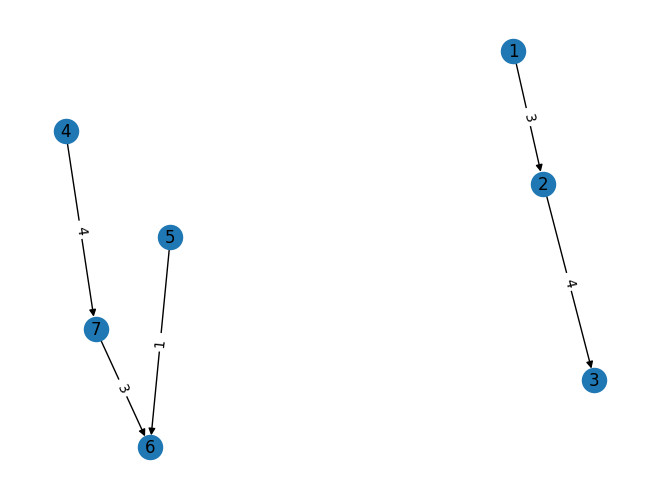

In [3]:
# Prompt user to input the path to the CSV file
file_path = "./temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
pretty_print_graph(graph)
plot(graph)

## Dataset Shifting and Preprocessing

In [4]:
from dowhy.timeseries.timeseries import find_lagged_parent_nodes

In [6]:
# read the dataframe in a csv format from the user, and then ask the user to select any 2 rows for 
# the effect estimation usecase
dataset_path="temporal_dataset.csv"
dataframe=pd.read_csv(dataset_path)

# the node for which effect estimation has to be done, node:6
child_node = "6"
# find the parent nodes of the given node with respective lag times
parents = find_lagged_parent_nodes(graph, child_node)
parents

{'5': 1, '7': 3}

In [7]:
from dowhy.timeseries.timeseries import shift_columns,filter_columns

In [8]:
time_shifted_df = shift_columns(dataframe,parents)
time_shifted_df.head()

,1,2,3,4,5,6,7
0,1,2,3,4,0.0,6,0.0
1,2,3,4,5,5.0,7,0.0
2,3,4,5,6,6.0,8,0.0
3,4,5,6,7,7.0,9,7.0
4,0,1,5,7,8.0,9,8.0


In [9]:
filtered_ts_df = filter_columns(time_shifted_df,child_node,parents)
filtered_ts_df.head()

,6,5,7
0,6,0.0,0.0
1,7,5.0,0.0
2,8,6.0,0.0
3,9,7.0,7.0
4,9,8.0,8.0


## Cause Estimation using Dowhy

In [10]:
# perform causal effect estimation on this new dataset
import dowhy
from dowhy import CausalModel

# Assuming 'df' is your DataFrame, 'treatment' is your treatment variable, and 'outcome' is your outcome variable
# Also assuming 'common_causes' is a list of common cause variables

model = CausalModel(
    data=filtered_ts_df,
    treatment='5',
    outcome='6',
    proceed_when_unidentifiable=True  # Proceed even if the causal graph is not fully identifiable
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[6])
d[5]      
Estimand assumption 1, Unconfoundedness: If U→{5} and U→6 then P(6|5,,U) = P(6|5,)

## Realized estimand
b: 6~5
Target units: ate

## Estimate
Mean value: 0.21739130434782616
p-value: [0.24486798]



/home/t-ashutoshs/miniconda3/envs/env_dowhy/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)
/home/t-ashutoshs/home/dowhy/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
